# Imports

In [58]:
! nvidia-smi

Thu Oct 15 04:57:37 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    39W / 250W |   1593MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [59]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, ReLU, ELU, LeakyReLU, Flatten, Dense, AveragePooling2D

import numpy as np
np.random.seed(666)
tf.random.set_seed(666)

In [60]:
options_phase0 = {
    'a_filter_size': [(1,1), (3,3), (5,5), (7,7), (9,9)],
    'a_include_BN': [True, False],
    'a_output_channels': [8, 16, 32, 64, 128, 256, 512],
    'activation_type': [ReLU, ELU, LeakyReLU],
    'b_filter_size': [(1,1), (3,3), (5,5), (7,7), (9,9)],
    'b_include_BN': [True, False],
    'b_output_channels': [8, 16, 32, 64, 128, 256, 512],
    'include_pool': [True, False],
    'pool_type': [MaxPool2D, AveragePooling2D]
    }

options = {
    'include_layer': [True, False],
    'a_filter_size': [(1,1), (3,3), (5,5), (7,7), (9,9)],
    'a_include_BN': [True, False],
    'a_output_channels': [8, 16, 32, 64, 128, 256, 512],
    'activation_type': [ReLU, ELU, LeakyReLU],
    'b_filter_size': [(1,1), (3,3), (5,5), (7,7), (9,9)],
    'b_include_BN': [True, False],
    'b_output_channels': [8, 16, 32, 64, 128, 256, 512],
    'include_pool': [True, False],
    'pool_type': [MaxPool2D, AveragePooling2D]
    }

In [61]:
# Load the training and testing set of CIFAR10
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

X_train = X_train.astype('float32')
X_train = X_train/255.

X_test = X_test.astype('float32')
X_test = X_test/255.

y_train = tf.reshape(tf.one_hot(y_train, 10), shape=(-1, 10))
y_test = tf.reshape(tf.one_hot(y_test, 10), shape=(-1, 10))

# Create TensorFlow dataset
BATCH_SIZE = 256
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(1024).cache().batch(BATCH_SIZE).prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.cache().batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [62]:
class Organism:
    def __init__(self,
                 chromosome={},
                 phase=0,
                 prevBestOrganism=None):
        '''
        chromosome is a dictionary of genes
        phase is the phase that the individual belongs to
        prevBestOrganism is the best organism of the previous phase
        '''
        self.phase = phase
        self.chromosome = chromosome
        self.prevBestOrganism=prevBestOrganism
        if phase != 0:
            # In a later stage, the model is made by
            # attaching new layers to the prev best model
            self.last_model = prevBestOrganism.model
    
    def build_model(self):
        '''
        This is the function to build the keras model
        '''
        keras.backend.clear_session()
        inputs = Input(shape=(32,32,3))
        if self.phase != 0:
            # Slice the prev best model
            # Use the model as a layer
            # Attach new layer to the sliced model
            intermediate_model = Model(inputs=self.last_model.input,
                                       outputs=self.last_model.layers[-3].output)
            for layer in intermediate_model.layers:
                # To make the iteration efficient
                layer.trainable = False
            inter_inputs = intermediate_model(inputs)
            x = Conv2D(filters=self.chromosome['a_output_channels'],
                       padding='same',
                       kernel_size=self.chromosome['a_filter_size'],
                       use_bias=self.chromosome['a_include_BN'])(inter_inputs)
            # This is to ensure that we do not randomly chose anothere activation
            self.chromosome['activation_type'] = self.prevBestOrganism.chromosome['activation_type']
        else:
            # For PHASE 0 only
            # input layer
            x = Conv2D(filters=self.chromosome['a_output_channels'],
                       padding='same',
                       kernel_size=self.chromosome['a_filter_size'],
                       use_bias=self.chromosome['a_include_BN'])(inputs)
        if self.chromosome['a_include_BN']:
            x = BatchNormalization()(x)
        x = self.chromosome['activation_type']()(x)
        if self.chromosome['include_pool']:
            x = self.chromosome['pool_type'](strides=(1,1),
                                             padding='same')(x)
        if self.phase != 0 and self.chromosome['include_layer'] == False:
            # Except for PHASE0, there is a choice for
            # the number of layers that the model wants
            if self.chromosome['include_skip']:
                y = Conv2D(filters=self.chromosome['a_output_channels'],
                           kernel_size=(1,1),
                           padding='same')(inter_inputs)
                x = Add()([y,x])
            x = GlobalAveragePooling2D()(x)
            x = Dense(10, activation='softmax')(x)
        else:
            # PHASE0 or no skip
            # in the tail
            x = Conv2D(filters=self.chromosome['b_output_channels'],
                       padding='same',
                       kernel_size=self.chromosome['b_filter_size'],
                       use_bias=self.chromosome['b_include_BN'])(x)
            if self.chromosome['b_include_BN']:
                x = BatchNormalization()(x)
            x = self.chromosome['activation_type']()(x)
            if self.chromosome['include_skip']:
                y = Conv2D(filters=self.chromosome['b_output_channels'],
                           padding='same',
                           kernel_size=(1,1))(inputs)
                x = Add()([y,x])
            x = GlobalAveragePooling2D()(x)
            x = Dense(10, activation='softmax')(x)
        self.model = Model(inputs=[inputs], outputs=[x])
        self.model.compile(optimizer='adam',
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])
    def fitnessFunction(self,
                        train_ds,
                        test_ds,
                        generation_number):
        '''
        This function is used to calculate the
        fitness of an individual.
        '''
        wandb.init(entity="authors",
                   project="vlga",
                   group='KAGp{}'.format(self.phase),
                   job_type='g{}'.format(generation_number))
        self.model.fit(train_ds,
                       epochs=3,
                       callbacks=[WandbCallback()],
                       verbose=0)
        _, self.fitness = self.model.evaluate(test_ds,
                                              verbose=0)
    def crossover(self,
                  partner,
                  generation_number):
        '''
        This function helps in making children from two
        parent individuals.
        '''
        child_chromosome = {}
        endpoint = np.random.randint(low=0, high=len(self.chromosome))
        for idx, key in enumerate(self.chromosome):
            if idx <= endpoint:
                child_chromosome[key] = self.chromosome[key]
            else:
                child_chromosome[key] = partner.chromosome[key]
        child = Organism(chromosome= child_chromosome, phase=self.phase, prevBestOrganism=self.prevBestOrganism)
        child.build_model()
        child.fitnessFunction(train_ds,
                              test_ds,
                              generation_number=generation_number)
        return child
    
    def mutation(self, generation_number):
        '''
        One of the gene is to be mutated.
        '''
        index = np.random.randint(0, len(self.chromosome))
        key = list(self.chromosome.keys())[index]
        if  self.phase != 0:
            self.chromosome[key] = options[key][np.random.randint(len(options[key]))]
        else:
            self.chromosome[key] = options_phase0[key][np.random.randint(len(options_phase0[key]))]
        self.build_model()
        self.fitnessFunction(train_ds,
                             test_ds,
                             generation_number=generation_number)
    
    def show(self):
        '''
        Util function to show the individual's properties.
        '''
        pp.pprint(self.chromosome)

In [63]:
def random_hyper(phase):
    if phase == 0:
        return {
        'a_filter_size': options_phase0['a_filter_size'][np.random.randint(len(options_phase0['a_filter_size']))],
        'a_include_BN': options_phase0['a_include_BN'][np.random.randint(len(options_phase0['a_include_BN']))],
        'a_output_channels': options_phase0['a_output_channels'][np.random.randint(len(options_phase0['a_output_channels']))],
        'activation_type': options_phase0['activation_type'][np.random.randint(len(options_phase0['activation_type']))],
        'b_filter_size': options_phase0['b_filter_size'][np.random.randint(len(options_phase0['b_filter_size']))],
        'b_include_BN': options_phase0['b_include_BN'][np.random.randint(len(options_phase0['b_include_BN']))],
        'b_output_channels': options_phase0['b_output_channels'][np.random.randint(len(options_phase0['b_output_channels']))],
        'include_pool': options_phase0['include_pool'][np.random.randint(len(options_phase0['include_pool']))],
        'pool_type': options_phase0['pool_type'][np.random.randint(len(options_phase0['pool_type']))],
        'include_skip': options_phase0['include_skip'][np.random.randint(len(options_phase0['include_skip']))]
        }
    else:
        return {
        'a_filter_size': options['a_filter_size'][np.random.randint(len(options['a_filter_size']))],
        'a_include_BN': options['a_include_BN'][np.random.randint(len(options['a_include_BN']))],
        'a_output_channels': options['a_output_channels'][np.random.randint(len(options['a_output_channels']))],
        'b_filter_size': options['b_filter_size'][np.random.randint(len(options['b_filter_size']))],
        'b_include_BN': options['b_include_BN'][np.random.randint(len(options['b_include_BN']))],
        'b_output_channels': options['b_output_channels'][np.random.randint(len(options['b_output_channels']))],
        'include_pool': options['include_pool'][np.random.randint(len(options['include_pool']))],
        'pool_type': options['pool_type'][np.random.randint(len(options['pool_type']))],
        'include_layer': options['include_layer'][np.random.randint(len(options['include_layer']))],
        'include_skip': options['include_skip'][np.random.randint(len(options['include_skip']))]
        }

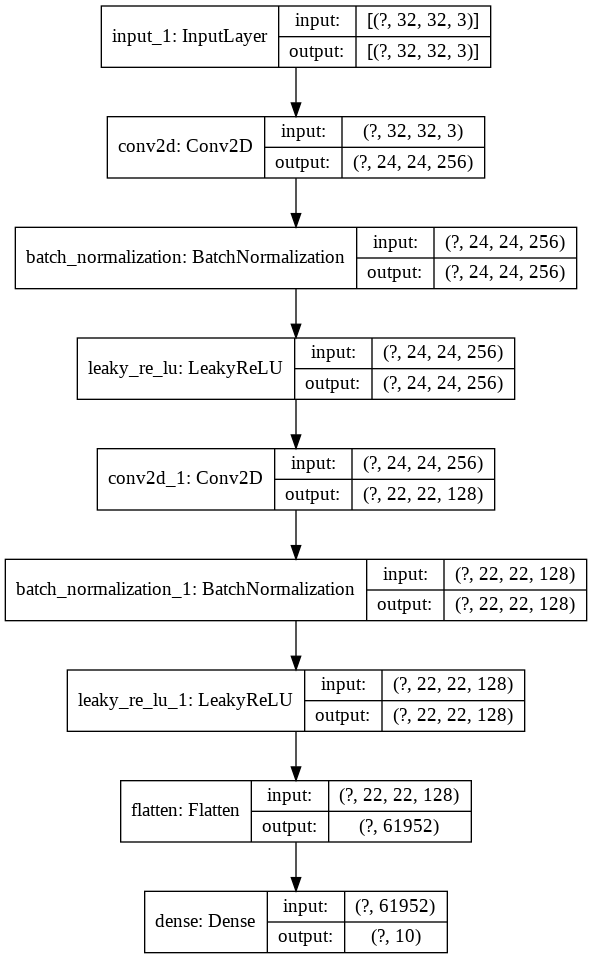

In [64]:
org1 = Organism(chromosome=random_hyper(phase=0), phase=0)
org1.build_model()
tf.keras.utils.plot_model(org1.model, show_shapes=True)

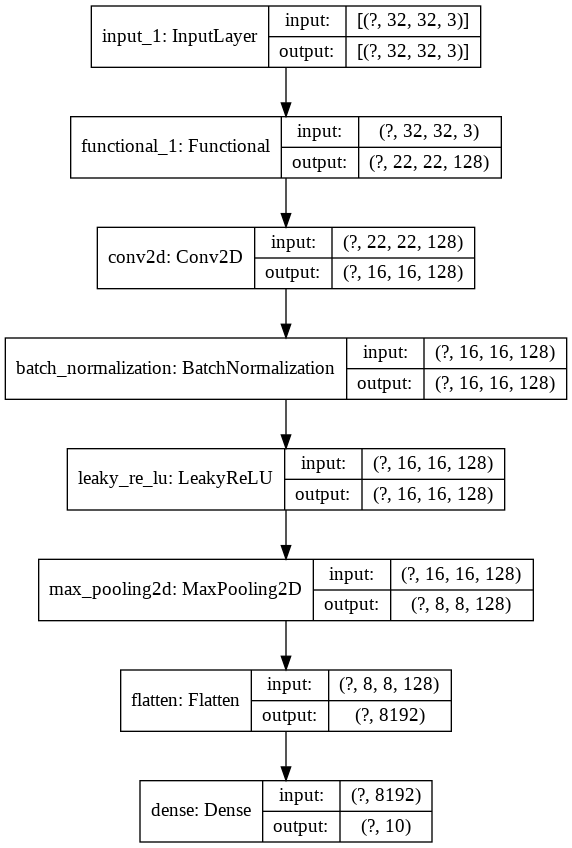

In [65]:
org2 = Organism(chromosome=random_hyper(phase=1), phase=1, last_model=org1.model)
org2.build_model()
tf.keras.utils.plot_model(org2.model, show_shapes=True)